## Import Libraries


In [1]:
import time
import librosa
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CyclicLR

import PyLTSpice
from PyLTSpice import RawRead
from scipy.interpolate import PchipInterpolator
from sklearn.model_selection import train_test_split
from datetime import datetime
from colorama import init, Fore, Style

## Read and Resample LTSpice .raw Files


In [2]:
spice_raw_path = '../ltspice/two_port_training_circuit/two_port_training_circuit.raw'
spice_raw = RawRead(spice_raw_path)
print('Traces: ', spice_raw.get_trace_names())

time_raw = spice_raw.get_axis()
time_duration = time_raw[-1]
print(f'Time duration: {time_duration}s')

v1_raw = spice_raw.get_trace('V(v1)').get_wave()
v2_raw = spice_raw.get_trace('V(v2)').get_wave()
va_raw = spice_raw.get_trace('V(va)').get_wave()
vb_raw = spice_raw.get_trace('V(vb)').get_wave()
vc_raw = spice_raw.get_trace('V(vc)').get_wave()
r1_raw = spice_raw.get_trace('V(vr1)').get_wave()
r2_raw = spice_raw.get_trace('V(vr2)').get_wave()
r3_raw = spice_raw.get_trace('V(vr3)').get_wave()

fs_target = 192e3
ts_target = 1.0 / fs_target
num_samples = np.floor(time_duration * fs_target).astype(int) + 1
time_resample = np.linspace(0, time_duration, num_samples)

v1 = PchipInterpolator(time_raw, v1_raw)(time_resample)
v2 = PchipInterpolator(time_raw, v2_raw)(time_resample)
va = PchipInterpolator(time_raw, va_raw)(time_resample)
vb = PchipInterpolator(time_raw, vb_raw)(time_resample)
vc = PchipInterpolator(time_raw, vc_raw)(time_resample)
r1 = PchipInterpolator(time_raw, r1_raw)(time_resample)
r2 = PchipInterpolator(time_raw, r2_raw)(time_resample)
r3 = PchipInterpolator(time_raw, r3_raw)(time_resample)

z11 = r1 + r3
z12 = -r3
z22 = r2 + r3

Traces:  ['time', 'V(va)', 'V(v1)', 'V(vc)', 'V(v2)', 'V(vb)', 'V(n001)', 'V(vr3)', 'V(vr1)', 'V(vr2)', 'V(v2_src)', 'I(R1)', 'I(R2)', 'I(R3)', 'I(B1)', 'Ic(Q1)', 'Ib(Q1)', 'Ie(Q1)', 'I(E1)', 'I(V1)', 'I(Vr3)', 'I(Vr1)', 'I(Vr2)', 'I(V2_src)']
Time duration: 10.0s


## Plot Resampled Data and I-V Curve Characteristic Curves


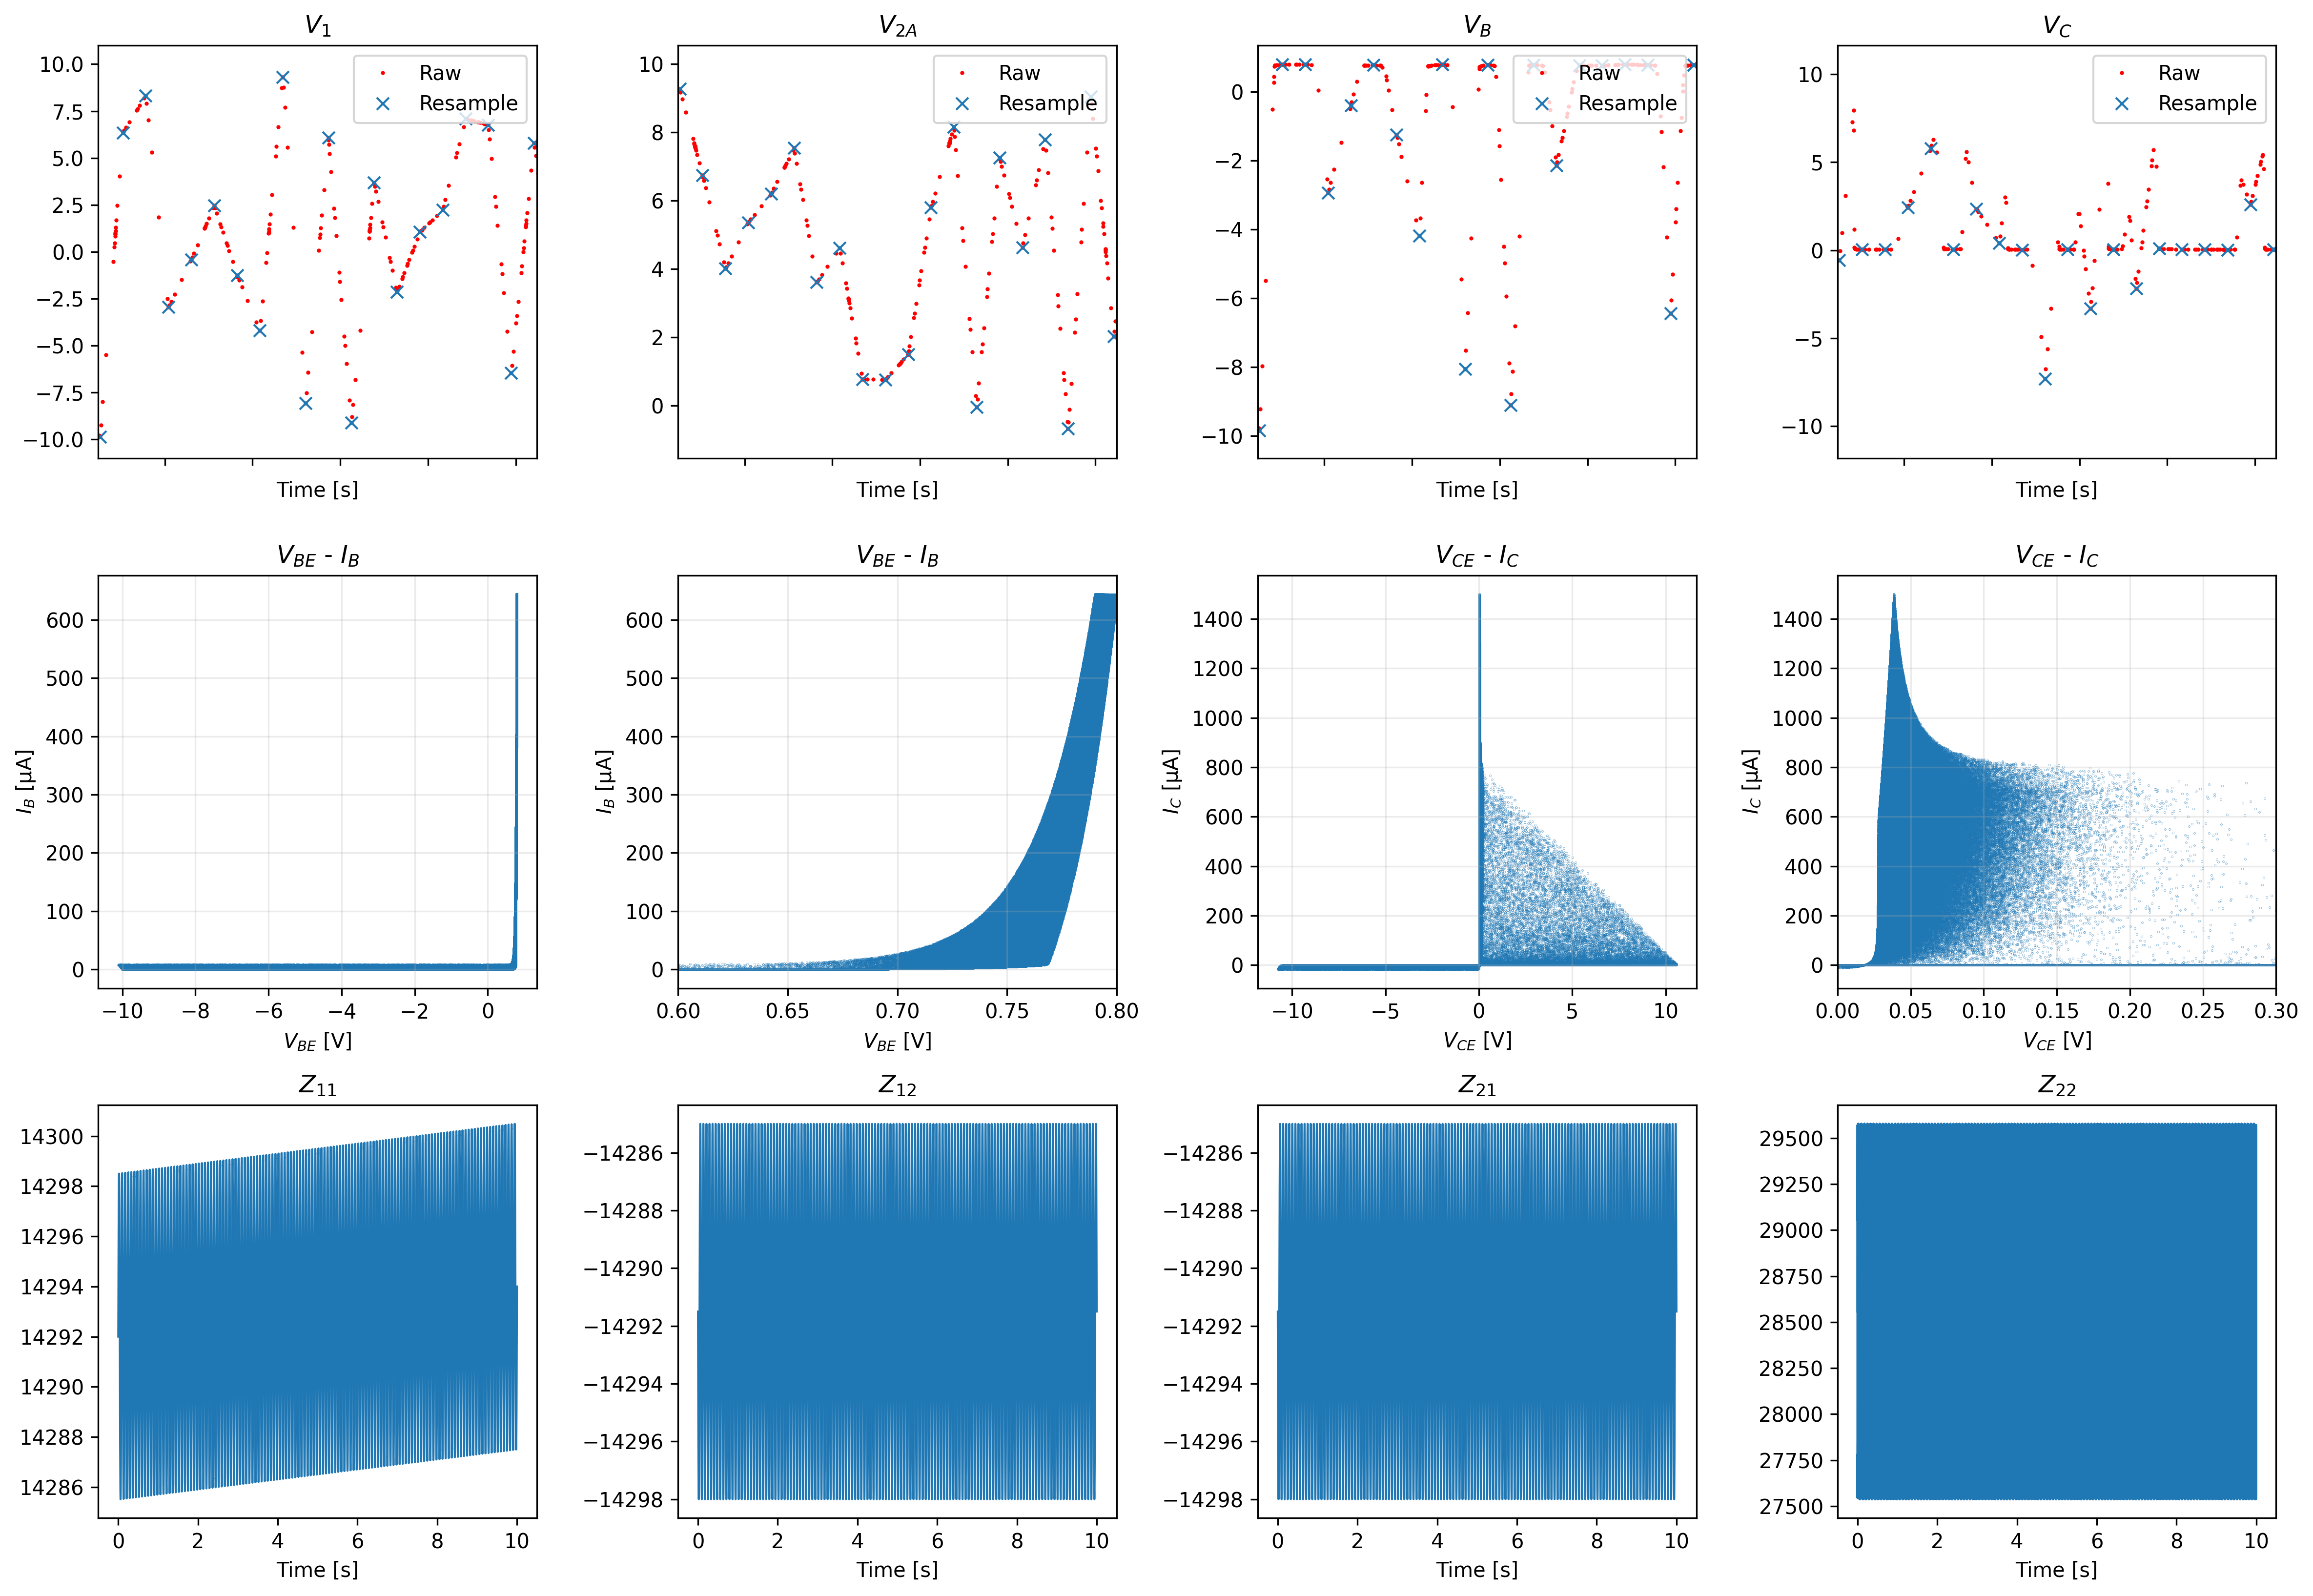

In [3]:
ib = (va - vb) / r3
ic = (v2 - vc) / r2
i1 = (v1 - va) / r1

fig, ((ax_v1, ax_v2, ax_vb, ax_vc), 
      (ax_ib, ax_ib_zoom, ax_ic, ax_ic_zoom), 
      (ax_z11, ax_z12, ax_z21, ax_z22)) = plt.subplots(3, 4, figsize=(16, 11), dpi=300)

markersize_raw = 1
markersize_resample = 6
legend_loc = 'upper right'
spot_size = 0.01
grid_alpha = 0.25

plot_duration = 1e-4
plot_start = np.random.uniform(0, time_duration - plot_duration)
plot_end = plot_start + plot_duration
xlim = (plot_start, plot_end)

ax_v1.plot(time_raw, v1_raw, 'ro', markersize=markersize_raw, label='Raw')
ax_v1.plot(time_resample, v1, 'x', markersize=markersize_resample, label='Resample')
ax_v1.set_xlim(xlim)
ax_v1.set_title(r'$V_1$')
ax_v1.set_xlabel('Time [s]')
ax_v1.legend(loc=legend_loc)
ax_v1.set_xticklabels([])  # 隐藏x轴标签

ax_v2.plot(time_raw, v2_raw - va_raw, 'ro', markersize=markersize_raw, label='Raw')
ax_v2.plot(time_resample, v2 - va, 'x', markersize=markersize_resample, label='Resample')
ax_v2.set_xlim(xlim)
ax_v2.set_title(r'$V_{2A}$')
ax_v2.set_xlabel('Time [s]')
ax_v2.legend(loc=legend_loc)
ax_v2.set_xticklabels([])  # 隐藏x轴标签

ax_vb.plot(time_raw, vb_raw, 'ro', markersize=markersize_raw, label='Raw')
ax_vb.plot(time_resample, vb, 'x', markersize=markersize_resample, label='Resample')
ax_vb.set_xlim(xlim)
ax_vb.set_title(r'$V_B$')
ax_vb.set_xlabel('Time [s]')
ax_vb.legend(loc=legend_loc)
ax_vb.set_xticklabels([])  # 隐藏x轴标签

ax_vc.plot(time_raw, vc_raw, 'ro', markersize=markersize_raw, label='Raw')
ax_vc.plot(time_resample, vc, 'x', markersize=markersize_resample, label='Resample')
ax_vc.set_xlim(xlim)
ax_vc.set_title(r'$V_C$')
ax_vc.set_xlabel('Time [s]')
ax_vc.legend(loc=legend_loc)
ax_vc.set_xticklabels([])  # 隐藏x轴标签

ax_ib.scatter(vb, ib*1e6, s=spot_size)
ax_ib.set_xlabel(r'$V_{BE}$ [V]')
ax_ib.set_ylabel(r'$I_B$ [μA]')
ax_ib.set_title(r'$V_{BE}$ - $I_B$')
ax_ib.grid(alpha=grid_alpha)

ax_ib_zoom.scatter(vb, ib*1e6, s=spot_size)
ax_ib_zoom.set_xlabel(r'$V_{BE}$ [V]')
ax_ib_zoom.set_ylabel(r'$I_B$ [μA]')
ax_ib_zoom.set_title(r'$V_{BE}$ - $I_B$')
ax_ib_zoom.set_xlim(0.6, 0.8)
ax_ib_zoom.grid(alpha=grid_alpha)

ax_ic.scatter(vc, ic*1e6, s=spot_size)
ax_ic.set_xlabel(r'$V_{CE}$ [V]')
ax_ic.set_ylabel(r'$I_C$ [μA]')
ax_ic.set_title(r'$V_{CE}$ - $I_C$')
ax_ic.grid(alpha=grid_alpha)

ax_ic_zoom.scatter(vc, ic*1e6, s=spot_size)
ax_ic_zoom.set_xlabel(r'$V_{CE}$ [V]')
ax_ic_zoom.set_ylabel(r'$I_C$ [μA]')
ax_ic_zoom.set_title(r'$V_{CE}$ - $I_C$')
ax_ic_zoom.set_xlim(0, 0.3)
ax_ic_zoom.grid(alpha=grid_alpha)

ax_z11.plot(time_resample, z11, linewidth=1)
ax_z11.set_xlabel('Time [s]')
ax_z11.set_title(r'$Z_{11}$')

ax_z12.plot(time_resample, z12, linewidth=1)
ax_z12.set_xlabel('Time [s]')
ax_z12.set_title(r'$Z_{12}$')

ax_z21.plot(time_resample, z12, linewidth=1)
ax_z21.set_xlabel('Time [s]')
ax_z21.set_title(r'$Z_{21}$')

ax_z22.plot(time_resample, z22, linewidth=1)
ax_z22.set_xlabel('Time [s]')
ax_z22.set_title(r'$Z_{22}$')


fig.tight_layout()
plt.show()
plt.close('all')

## Compute Incident and Reflected Waves


In [4]:
a1 = v1
a2 = v2 - va
b1 = 2 * vb - a1
b2 = 2 * (vc - vb) - a2

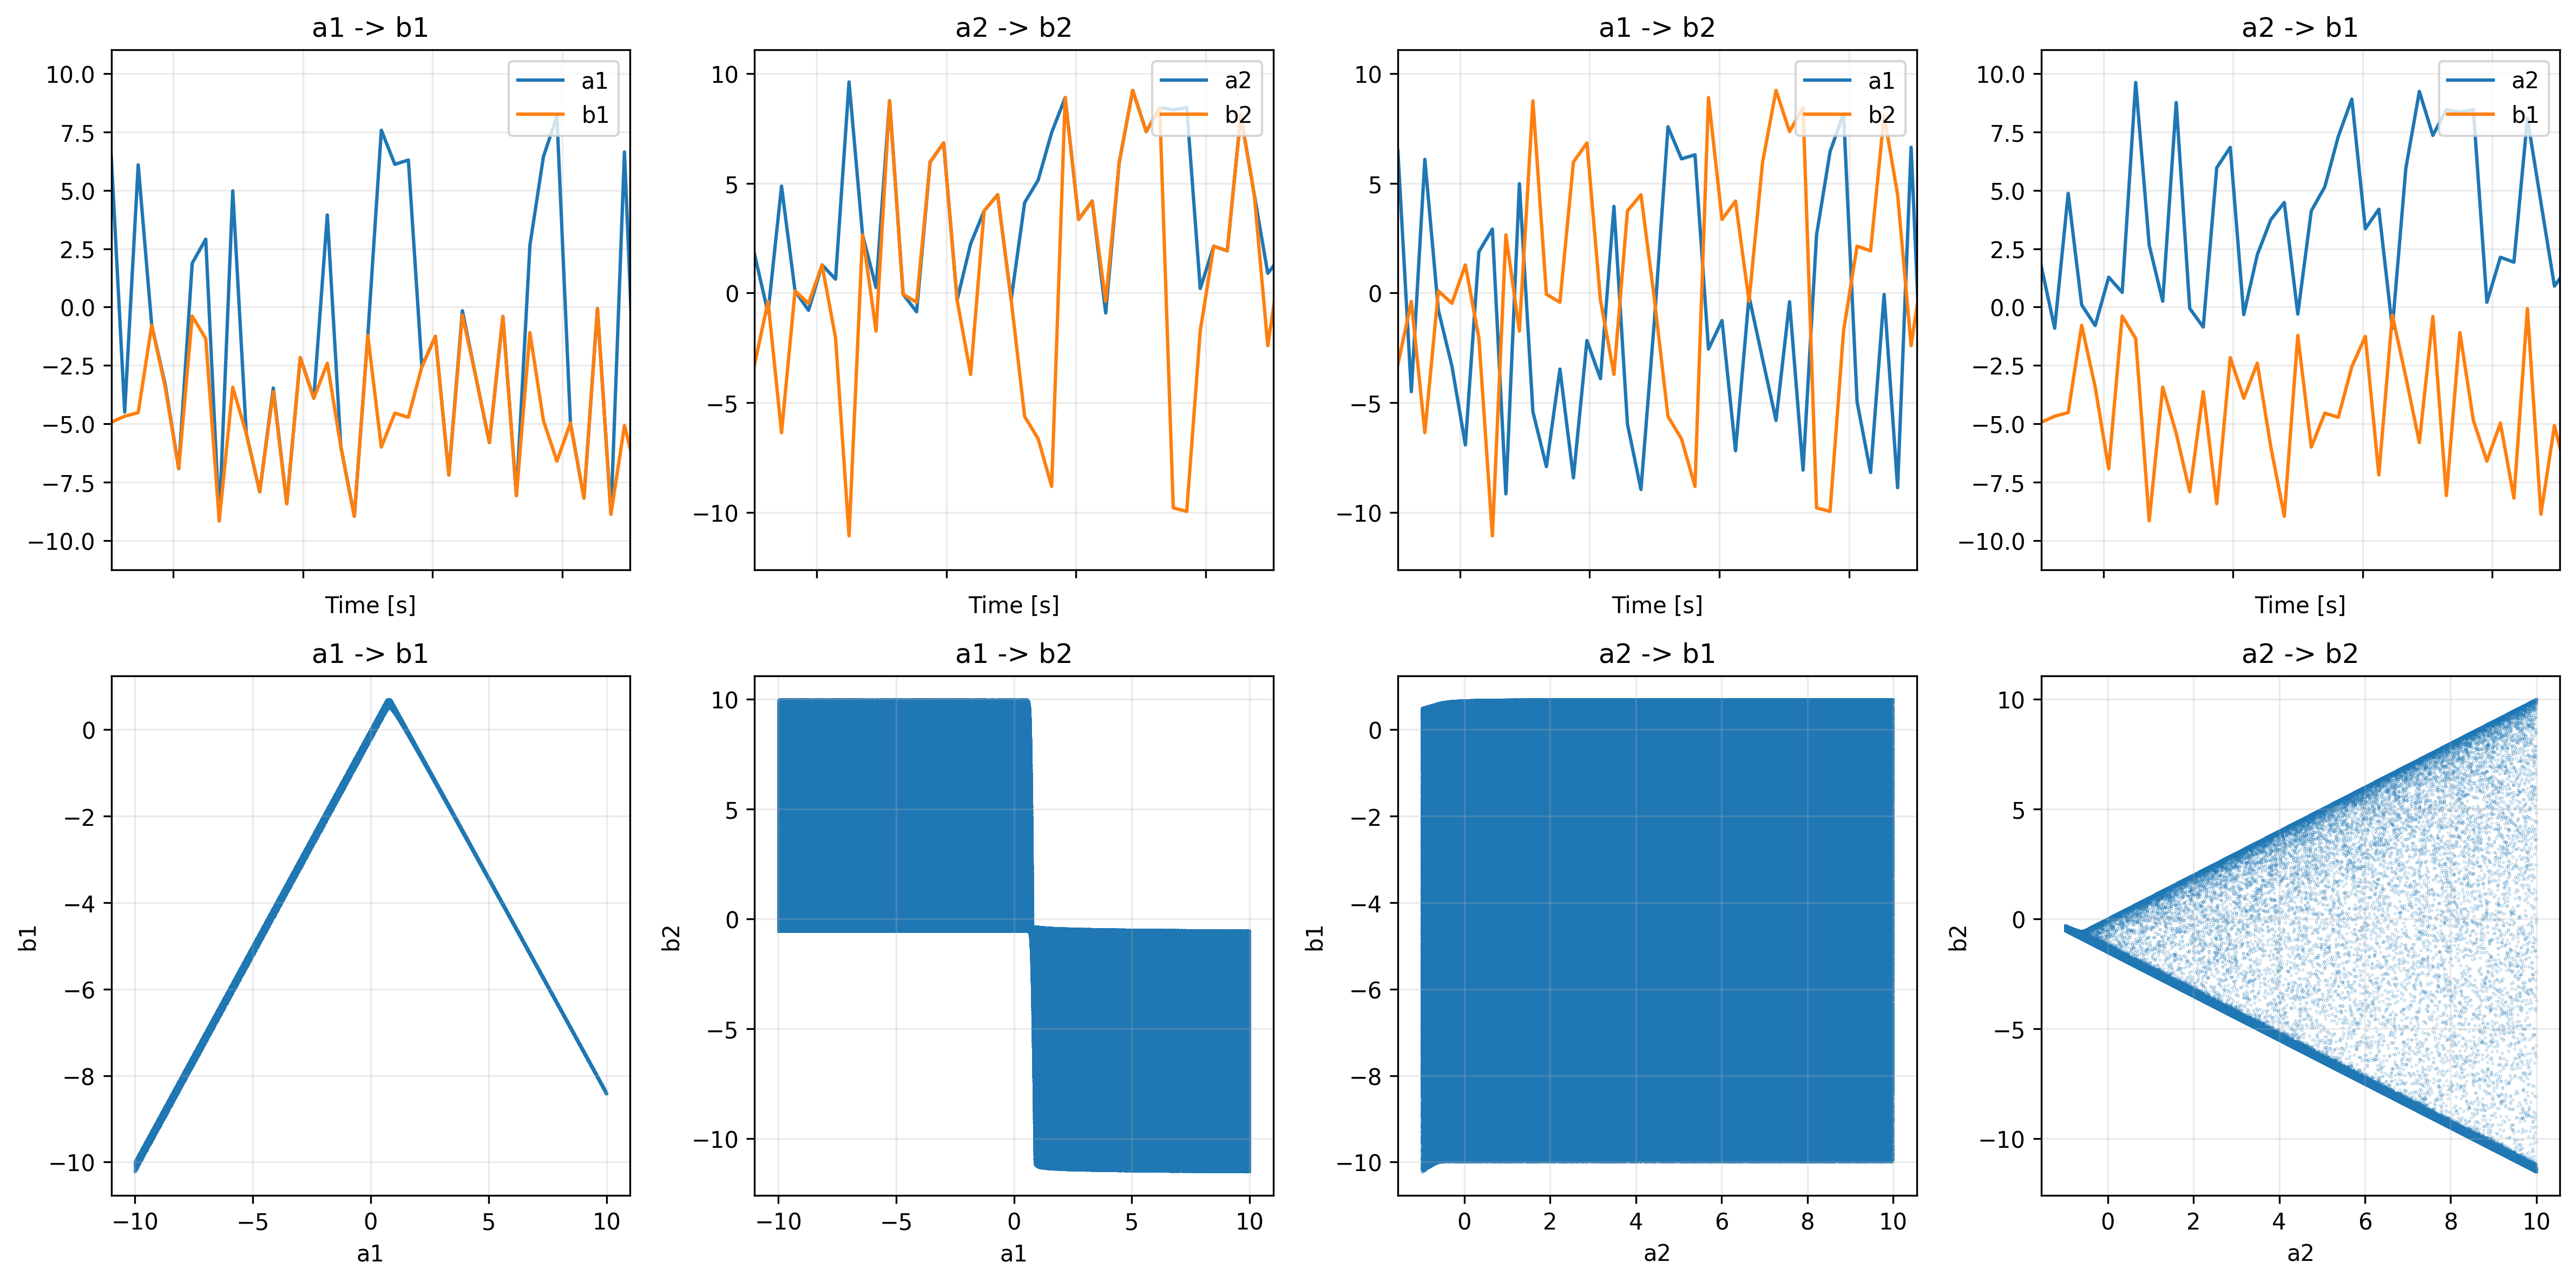

In [5]:
fig, ((ax1, ax2, ax3, ax4),
      (ax_a1b1, ax_a1b2, ax_a2b1, ax_a2b2)) = plt.subplots(2, 4, figsize=(16, 8), dpi=300)

legend_loc = 'upper right'
grid_alpha = 0.25

plot_duration = 2e-4
plot_start = np.random.uniform(0, time_duration - plot_duration)
plot_end = plot_start + plot_duration
xlim = (plot_start, plot_end)

ax1.plot(time_resample, a1, label='a1')
ax1.plot(time_resample, b1, label='b1')
ax1.set_title('a1 -> b1')
ax1.set_xlabel('Time [s]')
ax1.set_xlim(xlim)
ax1.grid(alpha=grid_alpha)
ax1.legend(loc=legend_loc)
ax1.set_xticklabels([])  # 隐藏x轴标签

ax2.plot(time_resample, a2, label='a2')
ax2.plot(time_resample, b2, label='b2')
ax2.set_title('a2 -> b2')
ax2.set_xlabel('Time [s]')
ax2.set_xlim(xlim)
ax2.grid(alpha=grid_alpha)
ax2.legend(loc=legend_loc)
ax2.set_xticklabels([])  # 隐藏x轴标签

ax3.plot(time_resample, a1, label='a1')
ax3.plot(time_resample, b2, label='b2')
ax3.set_title('a1 -> b2')
ax3.set_xlabel('Time [s]')
ax3.set_xlim(xlim)
ax3.grid(alpha=grid_alpha)
ax3.legend(loc=legend_loc)
ax3.set_xticklabels([])  # 隐藏x轴标签

ax4.plot(time_resample, a2, label='a2')
ax4.plot(time_resample, b1, label='b1')
ax4.set_title('a2 -> b1')
ax4.set_xlabel('Time [s]')
ax4.set_xlim(xlim)
ax4.grid(alpha=grid_alpha)
ax4.legend(loc=legend_loc)
ax4.set_xticklabels([])  # 隐藏x轴标签

ax_a1b1.scatter(a1, b1, s=spot_size)
ax_a1b1.set_xlabel('a1')
ax_a1b1.set_ylabel('b1')
ax_a1b1.set_title('a1 -> b1')
ax_a1b1.grid(alpha=grid_alpha)

ax_a1b2.scatter(a1, b2, s=spot_size)
ax_a1b2.set_xlabel('a1')
ax_a1b2.set_ylabel('b2')
ax_a1b2.set_title('a1 -> b2')
ax_a1b2.grid(alpha=grid_alpha)

ax_a2b1.scatter(a2, b1, s=spot_size)
ax_a2b1.set_xlabel('a2')
ax_a2b1.set_ylabel('b1')
ax_a2b1.set_title('a2 -> b1')
ax_a2b1.grid(alpha=grid_alpha)

ax_a2b2.scatter(a2, b2, s=spot_size)
ax_a2b2.set_xlabel('a2')
ax_a2b2.set_ylabel('b2')
ax_a2b2.set_title('a2 -> b2')
ax_a2b2.grid(alpha=grid_alpha)

fig.tight_layout()
plt.show()
plt.close('all')

## Data Loader


In [13]:
aR = np.stack((a1, a2, z11, z12, z22), axis=1)
b = np.stack((b1, b2), axis=1)

print(a1.shape)

a_train, a_valid, b_train, b_valid = train_test_split(
    aR, b,
    train_size=0.8,
    shuffle=True
)

train_ds = TensorDataset(
    torch.tensor(a_train, dtype=torch.float32),
    torch.tensor(b_train, dtype=torch.float32),
)
valid_ds = TensorDataset(
    torch.tensor(a_valid, dtype=torch.float32),
    torch.tensor(b_valid, dtype=torch.float32)
)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128 * 2)

(1920001,)


## Neural Two-Port Element


In [7]:
class GlobalNorm1d(nn.Module):
    def __init__(self, input_features, eps=None, affine=True):
        super(GlobalNorm1d, self).__init__()
        
        if eps is None:
            eps = torch.finfo(torch.float32).eps
        self.register_buffer('eps', torch.tensor(eps, dtype=torch.float32))
        
        self.register_buffer('count', torch.tensor(0., dtype=torch.float32))
        self.register_buffer('mean', torch.zeros(input_features, dtype=torch.float32))
        self.register_buffer('var', torch.ones(input_features, dtype=torch.float32))
        
        self.affine = affine
        self.weight = nn.Parameter(torch.ones(input_features, dtype=torch.float32)) if affine else None 
        self.bias = nn.Parameter(torch.zeros(input_features, dtype=torch.float32)) if affine else None
    
    def update_statistics(self, x):
        with torch.no_grad():
            batch_mean = x.mean(dim=0).to(self.mean.device)
            batch_count = x.size(0)
            total_count = self.count + batch_count
            # Update mean
            delta = batch_mean - self.mean
            self.mean += delta * batch_count / total_count
            # Update variance
            ratio = (self.count - 1) / (total_count - 1)
            batch_var = (x - batch_mean).pow(2).sum(dim=0)
            weighted_delta_square = delta.pow(2) * self.count * batch_count / total_count
            self.var *= ratio
            self.var += (batch_var + weighted_delta_square) / (total_count - 1)
            # Update count
            self.count = total_count
            
    def forward(self, x):
        self.update_statistics(x) if self.training else None
        normalized_x = (x - self.mean) / (self.var + self.eps).sqrt()
        return normalized_x * self.weight + self.bias if self.affine else normalized_x

        

class TwoPort(nn.Module):
    def __init__(self):
        super(TwoPort, self).__init__()
        self.gn1 = GlobalNorm1d(5)
        self.linear1 = nn.Linear(5, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.gn1(x)

        x1 = self.linear1(x)
        x1 = F.relu(x1)

        x2 = self.linear2(x1) + x1
        x2 = F.relu(x2)

        x3 = self.linear3(x2)
        return x3

## Loss Functions


In [8]:
class ESRLoss(nn.Module):
    def __init__(self):
        super(ESRLoss, self).__init__()

    def forward(self, y_true, y_pred):
        return torch.sum((y_true - y_pred)**2) / torch.sum(y_true**2)
    
class DCLoss(nn.Module):
    def __init__(self):
        super(DCLoss, self).__init__()

    def forward(self, y_true, y_pred):
        numerator = torch.abs(torch.mean(y_true - y_pred))**2
        denominator = torch.mean(y_true ** 2)
        return numerator / denominator

class CombinedSignalLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.MSE = nn.MSELoss()
        self.ESR = ESRLoss()

    def forward(self, y_target, y_pred):
        return self.MSE(y_target, y_pred) + self.ESR(y_target, y_pred)

## Training Loop


In [23]:
model = TwoPort()
model = torch.load('../models/2x16.pth')
loss_func_train = CombinedSignalLoss() 
loss_func_valid = nn.MSELoss()

epochs = 100
lr_init = 1e-5
optimizer = torch.optim.SGD(model.parameters(), lr=lr_init)
# scheduler_redu = ReduceLROnPlateau(optimizer, factor=0.5, patience=10, eps=2e-7)
scheduler_exp = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
# scheduler_cyc = CyclicLR(
#     optimizer,
#     base_lr=2e-7,
#     max_lr=1e-3,
#     step_size_up=5,
#     step_size_down=20,
#     mode='exp_range',
#     gamma=0.96,
#     cycle_momentum=False
# )

def train_one_epoch(model, train_dl, loss_func, optimizer):
    model.train()
    total_loss, total_samples = 0.0, 0
    for x, y in train_dl:
        pred = model(x)
        loss = loss_func(y, pred)
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return total_loss / total_samples

def evaluate(model, valid_dl, loss_func):
    model.eval()
    total_loss, total_samples = 0.0, 0
    with torch.no_grad():
        for x, y in valid_dl:
            pred = model(x)
            loss = loss_func(y, pred)
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)
    return total_loss / total_samples

start_time = time.time()
print(f"{'Epoch':>5}    {'Train Loss':>12}      {'Eval Loss(MSE)':>15}        {'Learning Rate'}     {'Time Left'}")
print("-"*80)
train_losses, valid_losses, learning_rate = [], [], []
best_loss = float('inf')
model_name = "best_model"
time_stamp = datetime.now().strftime("%Y%m%d_%H%M%S")

lr_last = lr_init
for epoch in range(epochs):
    start_time_epoch = time.time()
    train_loss = train_one_epoch(model, train_dl, loss_func_train, optimizer) 
    valid_loss = evaluate(model, valid_dl, loss_func_valid)
    
    lr_current = optimizer.param_groups[0]['lr']
    if lr_current != lr_last or epoch == 0:
        lr_last = lr_current
        lr_text = f"{lr_current:.2e}"
    else:
        lr_text = f"-"*10

    # scheduler_redu.step(valid_loss)
    # scheduler_cyc.step()
    # scheduler_exp.step()
    
    end_time_epoch = time.time()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    learning_rate.append(lr_current)
    
    print(f"{epoch+1:5d}  {train_loss:12.3e}  {valid_loss:15.3e}({20*np.log10(valid_loss):5.2f}dB)      {lr_text}     {(end_time_epoch-start_time_epoch)/60*(epochs-epoch-1):8.2f} min")

end_time = time.time()
print(f"\nTime cost: {(end_time - start_time)/60:.2f} min")

Epoch      Train Loss       Eval Loss(MSE)        Learning Rate     Time Left
--------------------------------------------------------------------------------
    1     1.046e-05        1.025e-05(-99.79dB)      1.00e-05        17.66 min
    2     1.101e-05        1.074e-05(-99.38dB)      ----------        17.49 min
    3     1.167e-05        1.143e-05(-98.84dB)      ----------        17.25 min
    4     1.250e-05        1.207e-05(-98.37dB)      ----------        17.07 min


KeyboardInterrupt: 

In [48]:
z11_mean_gt = z11.mean()
z12_mean_gt = z12.mean()
z22_mean_gt = z22.mean()
z11_var_gt = z11.var()
z12_var_gt = z12.var()
z22_var_gt = z22.var()

z_mean_est, z_var_est = model.gn1.mean, model.gn1.var

print(f"z11 mean\ntrue:{z11_mean_gt:.3f}\neval:{z_mean_est[2]:.3f}\n")
print(f"z11 var\ntrue:{z11_var_gt:.3f}\neval:{z_var_est[2]:.3f}\n")

print(f"z12 mean\ntrue:{z12_mean_gt:.3f}\neval:{z_mean_est[3]:.3f}\n")
print(f"z12 var\ntrue:{z12_var_gt:.3f}\neval:{z_var_est[3]:.3f}\n")

print(f"z22 mean\ntrue:{z22_mean_gt:.3f}\neval:{z_mean_est[4]:.3f}\n")
print(f"z22 var\ntrue:{z22_var_gt:.3f}\neval:{z_var_est[4]:.3f}\n")

z11 mean
true:14293.000
eval:14293.042

z11 var
true:21.427
eval:32.562

z12 mean
true:-14291.500
eval:-14291.543

z12 var
true:21.125
eval:32.193

z22 mean
true:28557.500
eval:28557.406

z22 var
true:513105.345
eval:1048576.000



## Save Trained Models


In [28]:
torch.save(model, f"../models/2x16.pth")

## Plot Loss Curves


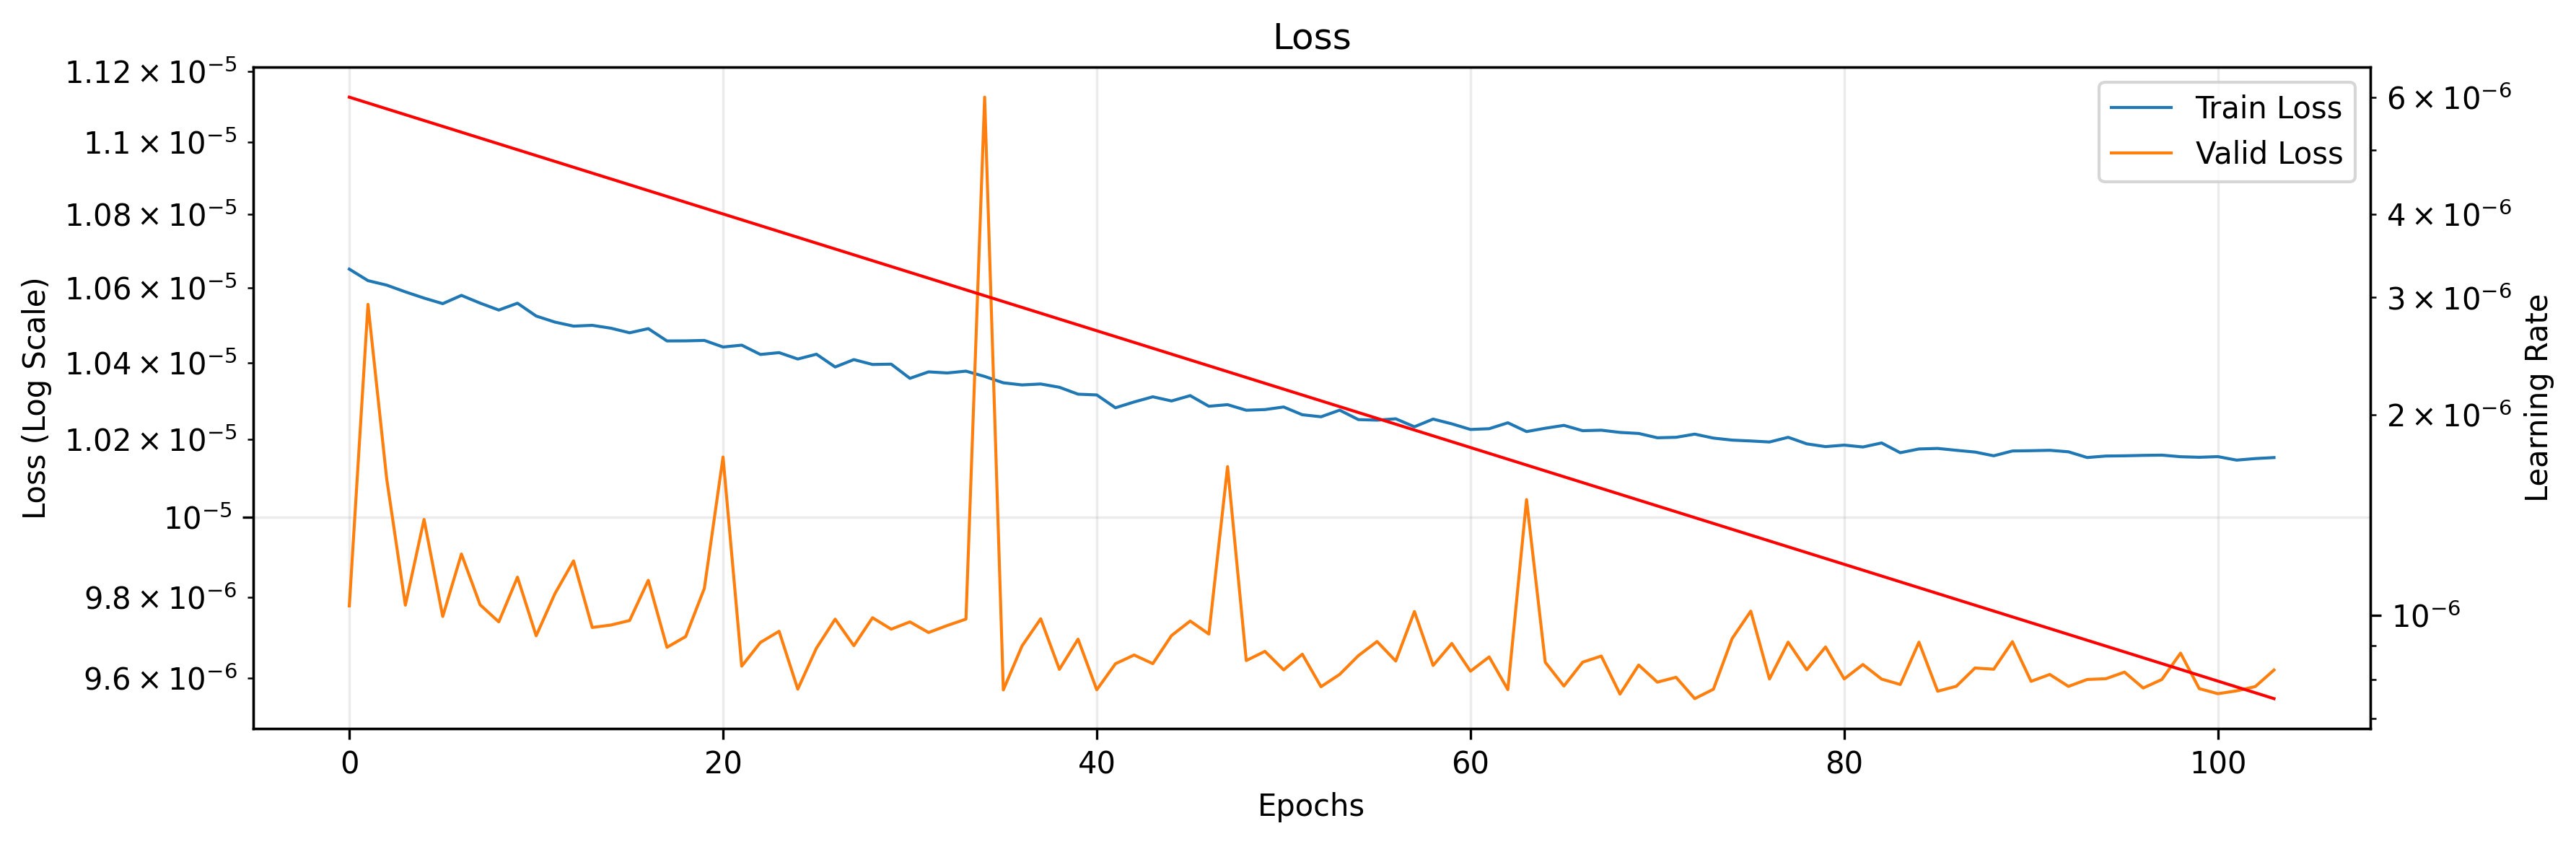

In [29]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 4), dpi=300)

ax1.plot(train_losses, linewidth=1, label='Train Loss')
ax1.plot(valid_losses, linewidth=1, label='Valid Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (Log Scale)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(alpha=0.25)

ax11 = ax1.twinx()
ax11.plot(learning_rate, linewidth=1, color='r', label='Learning Rate')
ax11.set_ylabel('Learning Rate')
ax11.set_yscale('log')
# ax11.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

fig.tight_layout()
plt.show()

## Validate Trained Models


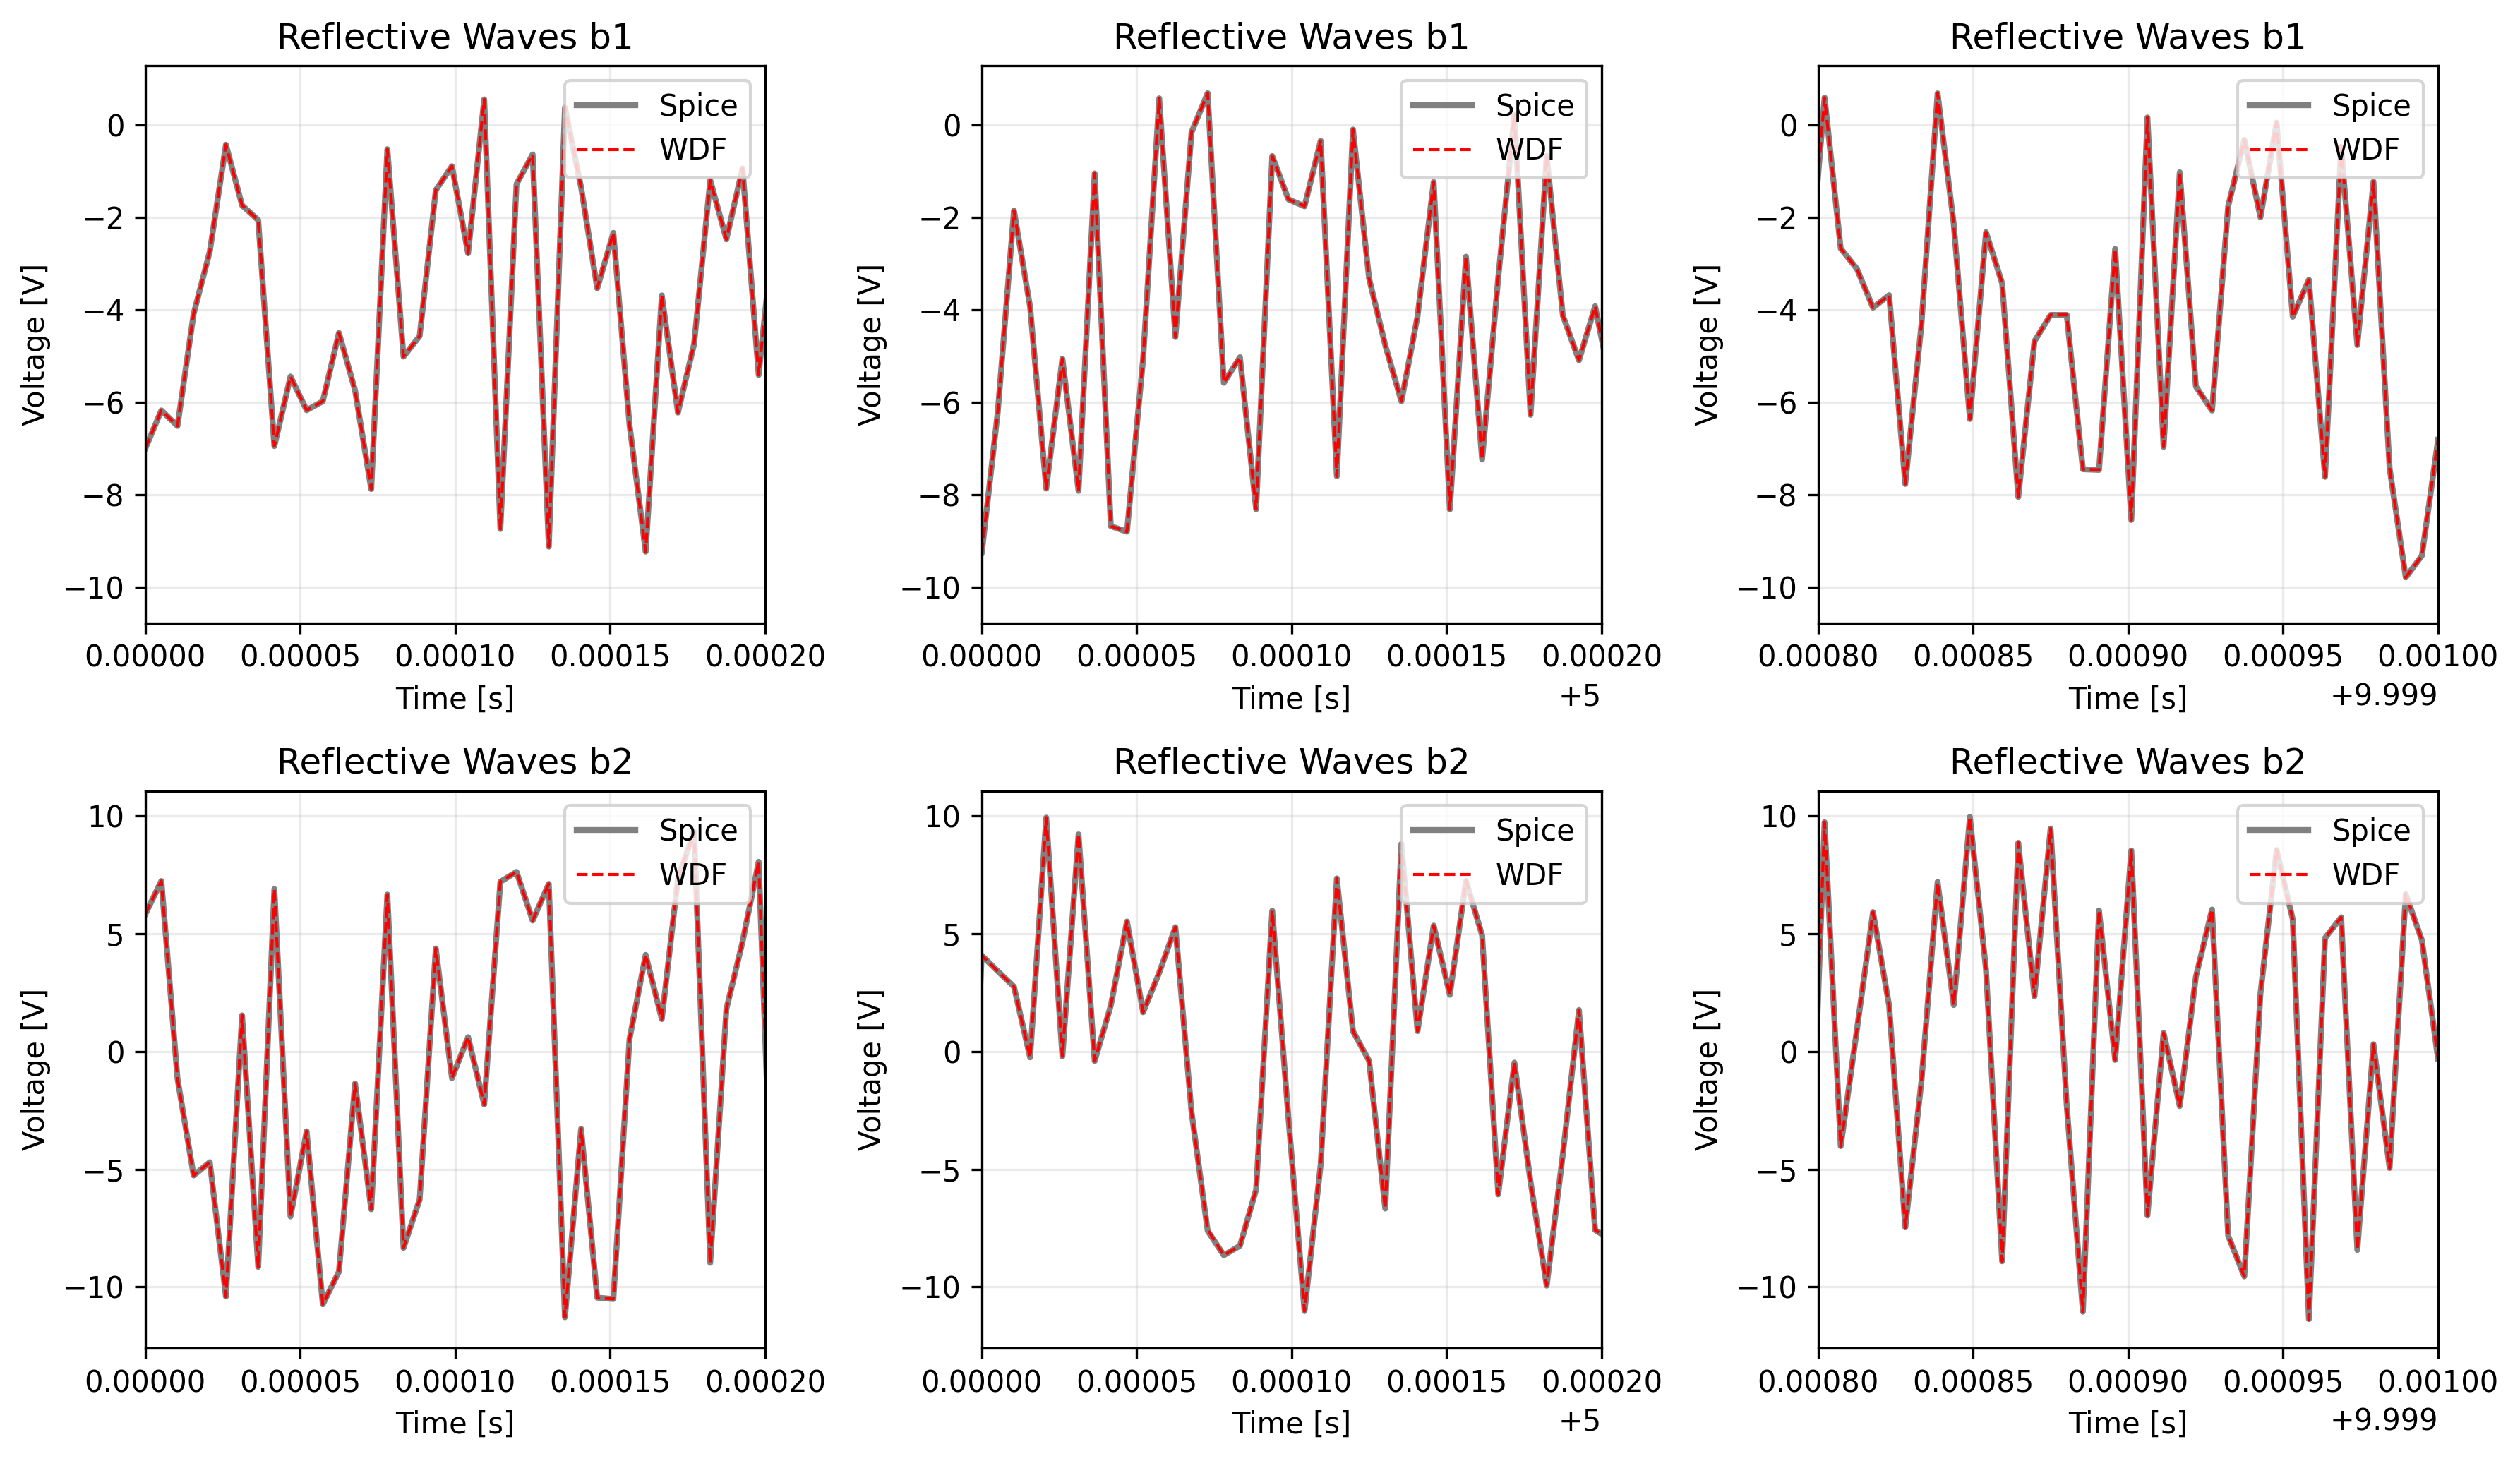

In [17]:
with torch.no_grad():
    b_pred = model(torch.tensor(aR, dtype=torch.float32))
    b_pred = b_pred.detach().numpy()

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 7), dpi=300)

plot_duration = 2e-4
linewidth_spice = 2
linewidth_wdf = 1
grid_alpha = 0.25

xlim_start = (0, plot_duration)
xlim_mid = (time_duration / 2, time_duration / 2 + plot_duration)
xlim_end = (time_duration - plot_duration, time_duration)

ax1.plot(time_resample, b1, color="grey", linewidth=linewidth_spice, label='Spice')
ax1.plot(time_resample, b_pred[:, 0], color="red", linewidth=linewidth_wdf, linestyle='--', label='WDF')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Voltage [V]')
ax1.set_title('Reflective Waves b1')
ax1.legend(loc='upper right')
ax1.grid(alpha=grid_alpha)
ax1.set_xlim(xlim_start)

ax4.plot(time_resample, b2, color="grey", linewidth=linewidth_spice, label='Spice')
ax4.plot(time_resample, b_pred[:, 1], color="red", linestyle='--', linewidth=linewidth_wdf, label='WDF')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Voltage [V]')
ax4.set_title('Reflective Waves b2')
ax4.legend(loc='upper right')
ax4.grid(alpha=grid_alpha)
ax4.set_xlim(xlim_start)

ax2.plot(time_resample, b1, color="grey", linewidth=linewidth_spice, label='Spice')
ax2.plot(time_resample, b_pred[:, 0], color="red", linestyle='--', linewidth=linewidth_wdf, label='WDF')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Voltage [V]')
ax2.set_title('Reflective Waves b1')
ax2.legend(loc='upper right')
ax2.grid(alpha=grid_alpha)
ax2.set_xlim(xlim_mid)

ax5.plot(time_resample, b2, color="grey", linewidth=linewidth_spice, label='Spice')
ax5.plot(time_resample, b_pred[:, 1], color="red", linestyle='--', linewidth=linewidth_wdf, label='WDF')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Voltage [V]')
ax5.set_title('Reflective Waves b2')
ax5.legend(loc='upper right')
ax5.grid(alpha=grid_alpha)
ax5.set_xlim(xlim_mid)

ax3.plot(time_resample, b1, color="grey", linewidth=linewidth_spice, label='Spice')
ax3.plot(time_resample, b_pred[:, 0], color="red", linestyle='--', linewidth=linewidth_wdf, label='WDF')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Voltage [V]')
ax3.set_title('Reflective Waves b1')
ax3.legend(loc='upper right')
ax3.grid(alpha=grid_alpha)
ax3.set_xlim(xlim_end)

ax6.plot(time_resample, b2, color="grey", linewidth=linewidth_spice, label='Spice')
ax6.plot(time_resample, b_pred[:, 1], color="red", linestyle='--', linewidth=linewidth_wdf, label='WDF')
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Voltage [V]')
ax6.set_title('Reflective Waves b2')
ax6.legend(loc='upper right')
ax6.grid(alpha=grid_alpha)
ax6.set_xlim(xlim_end)

fig.tight_layout()
plt.show()